# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Importing libraries and datasets

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Data Understanding

In [2]:
# Verifying portfolio dataframe
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [3]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# Verifying profile dataframe
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [5]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [6]:
# Verifying transcript dataframe
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [7]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


### 2. Data Exploration

#### 2.1 Profile dataset

Text(0.5,0,'Age')

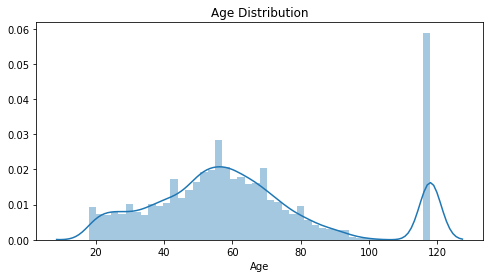

In [8]:
plt.figure(figsize=(8, 4))
sns.distplot(profile['age'])
plt.title('Age Distribution')
plt.xlabel('Age')

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
# Checking number of rows with age 118
profile[profile['age'] == 118].shape[0]

2175

From the plot and the describe function above, it is possible to verify outliers on the 'Age' column of the profile dataset.

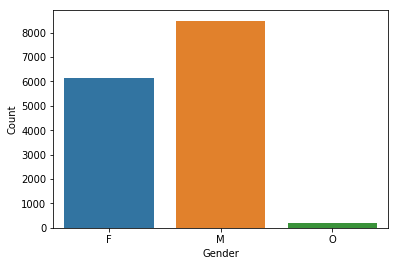

In [11]:
# Verifying gender distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=profile)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### 2.2 Portfolio dataset

In [12]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Portfolio dataset also has all 3 channels combined on the 'Channels' column.

In [13]:
# Verifying unique offer types in dataset
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [14]:
# counting number of offer by types
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [15]:
portfolio['id'].nunique()

10

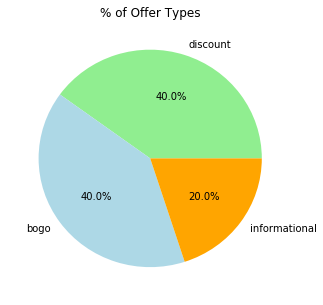

In [16]:
# Counts of offer type
offer_types = portfolio['offer_type'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(offer_types, labels=offer_types.index, autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'orange', 'lightskyblue'])
plt.title('% of Offer Types')
plt.show()

It is possible to observe that the number of IDs is equal to the number of rows on the Portfolio dataset.

#### 2.3 Transcript dataset

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript['person'].nunique()

17000

In [19]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### 3. Data Cleaning

Data cleaning on Profile dataframe:

* Correct date format of 'became_member_on' column
* Replace age 118 with NaN
* Create dummy variables from 'gender' column
* Rename 'id' column to 'customer_id'

In [20]:
# creating copy of Profile dataset to clean it
df2 = profile.copy()
df2.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [21]:
def clean_profile(profile):
    
    '''
    Function to clean profile dataframe.
    
    INPUT - Profile dataframe
    
    OUTPUT - Return cleaned version of profile dataframe
    
    '''
    
    # Transforming became_member_on data type to datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

    # Replacing age 118 with nan
    profile['age'] = profile['age'].apply(lambda x: np.nan if x ==118 else x)
    
    # Creating dummy columns for gender 
    genders = pd.get_dummies(profile['gender'],prefix = "gender", prefix_sep = "-")
    profile = pd.concat([profile,genders],axis=1)
    
    # Renaming id to customer_id
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    return profile
    

profile_cleaned = clean_profile(df2)
df2.head(10)

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,NaN,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,NaN,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,NaN,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


Data cleaning on Portfolio dataframe:

* Extraction of channels from 'channels' column
* Creation of dummy variables on 'offer_type' column
* Drop of 'channel' and 'offer_type' columns

In [22]:
# Creating copy of portfolio dataset
df3 = portfolio.copy()

In [23]:
def clean_portfolio(portfolio):
    '''
    Function to clean the portfolio DataFrame.

    INPUT:
    - portfolio: DataFrame containing offer portfolio information

    OUTPUT:
    - Cleaned version of the portfolio DataFrame
    '''

    # Extracting channels from column and creating dummy columns
    channels = ['web', 'email', 'mobile', 'social']
    for channel in channels:
        portfolio['' + channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

    # Converting offer_type to 1 or 0
    offer_types = ['bogo', 'discount', 'informational']
    for offer_type in offer_types:
        portfolio['offer_type_' + offer_type] = (portfolio['offer_type'] == offer_type).astype(int)

    # Dropping the 'channels' and 'offer_type' columns
    portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    portfolio.rename(columns={'id':'offer_id'},inplace=True)

    return portfolio

portfolio_cleaned = clean_portfolio(df3)
portfolio_cleaned.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


Data cleaning on Transcript dataframe:

* Extraction offer_id from value column
* Split reward and amount values
* Drop of 'value' column
* Rename 'person' column to 'customer_id'

In [24]:
# Creating copy of portfolio dataset
df4 = transcript.copy()
df4.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [25]:
def clean_transcript(transcript):
    """
    Function to clean the transcript DataFrame.

    INPUT:
    - transcript: DataFrame containing transaction data

    OUTPUT:
    - Cleaned version of the transcript DataFrame
    """
    # Extracting offer_id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))

    # Splitting reward and amount values
    for i in ['reward', 'amount']:
        transcript[i] = transcript['value'].apply(lambda x: x[i] if i in x else None)

    # Dropping 'value' column
    transcript.drop('value', axis=1, inplace=True)

    # Renaming 'person' column to 'customer_id'
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)

    return transcript

# Creating cleanned dataframe
transcript_cleaned = clean_transcript(df4)
transcript_cleaned.head()

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


To determine which offers were successful, we will go through an additional transformation step, as some offers are completed but weren't viewed, which means the offer didn't result in a transaction.

In [26]:
def transform_transcript(transcript):
    '''
    Function to show successful and unsuccesful offers from transcript dataframe.
    
    Input - Transcript dataframe 
    
    Output - transformed transcript dataframe
     
    '''
    # Grouping values of offers
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    #Replacing nan values with 0.0
    
    offer_customer.fillna(0.0, inplace = True)
    
    # Values of offers completed and offers viewed greater than 1 means that it was a successful offer.    
    # By multiplying both columns, it is possible to verify successful offers.

    offer_customer['successful offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    
    offer_customer['successful offer'] = offer_customer['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_customer.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
                                                        
                
    return offer_customer

transcript_cleaned = transform_transcript(df4)
transcript_cleaned.head()

event,customer_id,offer_id,successful offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


In [27]:
# Merging all datasets together

def merge_dataframes(profile, portfolio, transcript):
    """
    Merge the profile, portfolio, and transcript dataframes into a single dataframe.

    Parameters:
    - profile (pd.DataFrame): The profile dataframe.
    - portfolio (pd.DataFrame): The portfolio dataframe.
    - transcript (pd.DataFrame): The transcript dataframe.

    Returns:
    - pd.DataFrame: Merged dataframe.
    """
    merged = transcript.merge(portfolio,how='left',on='offer_id')    
    merged = merged.merge(profile,how='left',on='customer_id')    
    
    return merged


merged_df = merge_dataframes(profile_cleaned,portfolio_cleaned,transcript_cleaned)

merged_df.head()

,customer_id,offer_id,successful offer,difficulty,duration,reward,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,gender,income,gender-F,gender-M,gender-O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,10,7,2,1,1,1,0,0,1,0,33.0,2017-04-21,M,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,4,0,1,1,1,0,0,0,1,33.0,2017-04-21,M,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,0,0,1,1,1,0,0,1,33.0,2017-04-21,M,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,1,0,0,33.0,2017-04-21,M,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,10,10,2,1,1,1,1,0,1,0,33.0,2017-04-21,M,72000.0,0,1,0


In [28]:
merged_df.shape

(63288, 20)

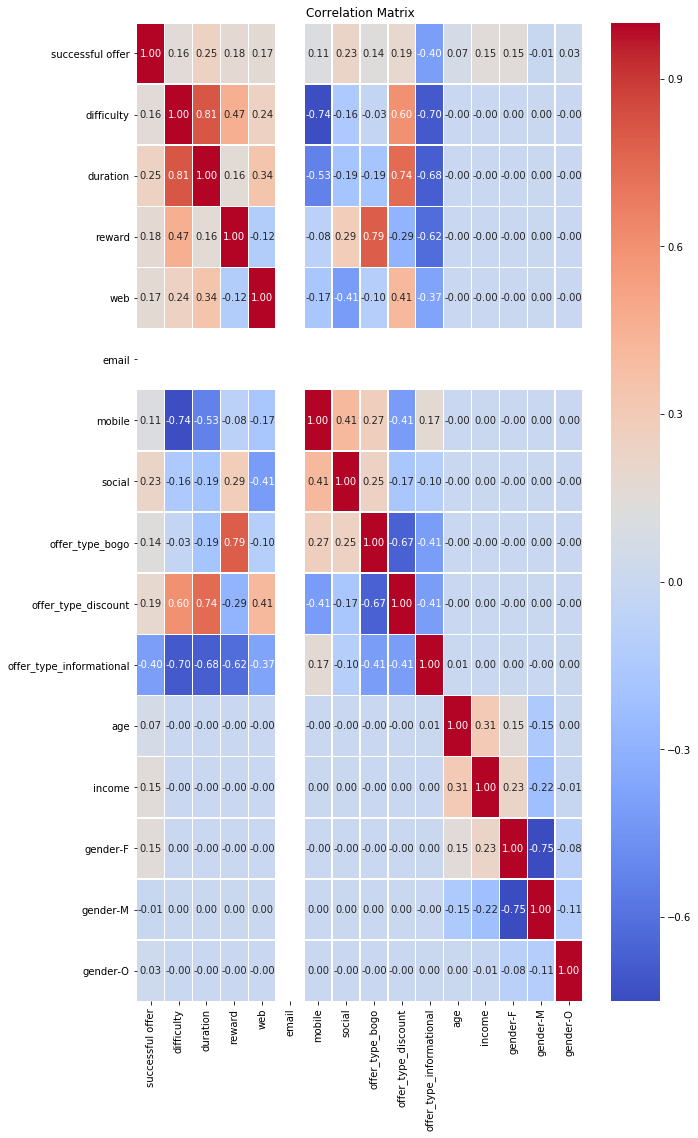

In [56]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 18))

# Plot the heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

By verifying the correlation between the metrics, with the target of a 'successful offer', it was decided to chose the 'difficulty', 'duration', 'reward', 'age', 'income' and 'gender' features to run the machine learning model. Gender values from the 'gender' column will be encoded and the dummy gender columns previously created won't be considered.

## 4. Modelling

To define the best model to be utilized, accuracy and F1-score (as it combines both precision and recall into a single value) will be evaluated. Gradient Boosting, Decision Tree and Ada Boost were the chosen models to predict a successful offer, followed by hyper parameter tunnings to identify the best option.

In [29]:
df_prep = merged_df[['difficulty', 'duration', 'reward', 'age', 'income', 'gender', 'successful offer']]
df_prep.head()
df_prep.describe()

,difficulty,duration,reward,age,income,successful offer
count,63288.000000,63288.000000,63288.000000,55222.000000,55222.000000,63288.000000
mean,7.711572,6.504819,4.206232,54.349969,65388.595125,0.386487
std,5.541480,2.203565,3.402914,17.392733,21626.373809,0.486948
min,0.000000,3.000000,0.000000,18.000000,30000.000000,0.000000
25%,5.000000,5.000000,2.000000,42.000000,49000.000000,0.000000
50%,10.000000,7.000000,5.000000,55.000000,63000.000000,0.000000
75%,10.000000,7.000000,5.000000,66.000000,80000.000000,1.000000
max,20.000000,10.000000,10.000000,101.000000,120000.000000,1.000000


In [30]:
# Encoding Gender to run ML models
def encode_gender(df):
    """
    Encodes the 'gender' column values to numeric representations.

    Parameters:
    - df: DataFrame to be processed.

    Returns:
    - DataFrame with 'gender' column values encoded to numeric representations.
    """
    # Dictionary to map genders to numeric values
    gender_mapping = {'F': 1, 'M': 2, 'O': 3}

    # Copy of the DataFrame to avoid the SettingWithCopyWarning
    df_copy = df.copy()

    # Map the gender values to their corresponding numeric values using the dictionary
    df_copy['gender'] = df_copy['gender'].map(gender_mapping).fillna(0).astype(int)

    return df_copy

df_prep = encode_gender(df_prep)
df_prep.head(10)

,difficulty,duration,reward,age,income,gender,successful offer
0,10,7,2,33.0,72000.0,2,0.0
1,0,4,0,33.0,72000.0,2,0.0
2,0,3,0,33.0,72000.0,2,0.0
3,5,5,5,33.0,72000.0,2,1.0
4,10,10,2,33.0,72000.0,2,1.0
5,5,5,5,NaN,NaN,0,0.0
6,20,10,5,40.0,57000.0,3,1.0
7,7,7,3,40.0,57000.0,3,1.0
8,0,4,0,40.0,57000.0,3,0.0
9,0,3,0,40.0,57000.0,3,0.0


In [31]:
# Dropping NaN rows to run ML algorithms
df_prep = df_prep.dropna()
df_prep.head(10)

,difficulty,duration,reward,age,income,gender,successful offer
0,10,7,2,33.0,72000.0,2,0.0
1,0,4,0,33.0,72000.0,2,0.0
2,0,3,0,33.0,72000.0,2,0.0
3,5,5,5,33.0,72000.0,2,1.0
4,10,10,2,33.0,72000.0,2,1.0
6,20,10,5,40.0,57000.0,3,1.0
7,7,7,3,40.0,57000.0,3,1.0
8,0,4,0,40.0,57000.0,3,0.0
9,0,3,0,40.0,57000.0,3,0.0
10,5,7,5,40.0,57000.0,3,1.0


In [32]:
# Selecting features for the model
X = df_prep[['difficulty', 'duration', 'reward', 'age', 'income', 'gender']]
y = df_prep['successful offer']

In [33]:
# Creating function to run models
def train_and_evaluate_classifier(X, y, classifier_type='gradient_boosting', random_state=42):
    """
    Train and evaluate a classifier.

    Parameters:
    - X (array-like): Feature matrix.
    - y (array-like): Target vector.
    - classifier_type (str, optional): Type of classifier ('gradient_boosting', 'adaboost', or 'decision_tree').
                                       Default is 'gradient_boosting'.
    - random_state (int, optional): Seed for random state for reproducibility. Default is 42.

    Returns:
    None

    Prints the accuracy score and classification report for the trained model on the test set.
    """
    # Spliting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Initializing classifier based on the specified type
    if classifier_type == 'gradient_boosting':
        classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state)
    elif classifier_type == 'adaboost':
        classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, learning_rate=0.1, random_state=random_state)
    elif classifier_type == 'decision_tree':
        classifier = DecisionTreeClassifier(max_depth=3, random_state=random_state)
    else:
        raise ValueError("Invalid classifier_type. Choose from 'gradient_boosting', 'adaboost', or 'decision_tree'.")

    # Training model
    classifier.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculating accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {accuracy:.4f}")

    # Generating classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

In [35]:
# Running Gradient Boosting algorithm
train_and_evaluate_classifier(X, y, classifier_type='gradient_boosting', random_state=42)

Accuracy Score: 0.7418
Classification Report:
             precision    recall  f1-score   support

        0.0       0.80      0.74      0.77      6362
        1.0       0.68      0.74      0.71      4683

avg / total       0.75      0.74      0.74     11045



In [36]:
# Running Decision Tree algorithm
train_and_evaluate_classifier(X, y, classifier_type='decision_tree', random_state=42)

Accuracy Score: 0.7040
Classification Report:
             precision    recall  f1-score   support

        0.0       0.78      0.68      0.72      6362
        1.0       0.63      0.74      0.68      4683

avg / total       0.72      0.70      0.71     11045



In [37]:
# Running Ada Boost algorithm
train_and_evaluate_classifier(X, y, classifier_type='adaboost', random_state=42)

Accuracy Score: 0.7439
Classification Report:
             precision    recall  f1-score   support

        0.0       0.79      0.75      0.77      6362
        1.0       0.68      0.74      0.71      4683

avg / total       0.75      0.74      0.74     11045



From the results above (without improving the models) Ada Boost shows the best results with an accuracy of 74.39%

### 4.1 Hyper parameter with GridSearchCV tunning

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Gradient Boosting Hyper parameter tunning
clf = GradientBoostingClassifier(random_state=42)
param_grid = { 'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5]}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
y_pred = grid_search.predict(X_test)
classification_rep = classification_report(y_test, y_pred) 
print("Classification Report:")
print(classification_rep)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Classification Report:
             precision    recall  f1-score   support

        0.0       0.79      0.76      0.77      7932
        1.0       0.69      0.73      0.71      5874

avg / total       0.75      0.75      0.75     13806



In [47]:
# Cross-validation
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)

# Perform cross-validation with 5 folds
scores = cross_val_score(model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean CV Score:", scores.mean())

Cross-Validation Scores: [ 0.73653237  0.74703486  0.74332277  0.73578414  0.7515168 ]
Mean CV Score: 0.742838185925


In [52]:
# Decision Tree hyper parameter tunning
param_grid = { 'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4] }
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Classification Report:
             precision    recall  f1-score   support

        0.0       0.80      0.75      0.77      7932
        1.0       0.69      0.74      0.71      5874

avg / total       0.75      0.75      0.75     13806



In [53]:
# Cross-validation

# Initializing Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2)

# Performing cross-validation and print the scores
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Average accuracy:", cv_scores.mean())

Cross-validation scores: [ 0.70946129  0.70774106  0.6966048   0.69386092  0.70551481]
Average accuracy: 0.702636575655


In [50]:
# Ada Boost Hyper parameter tunning
ada_boost = AdaBoostClassifier()
param_grid = { 'n_estimators': [50, 100, 150], 'learning_rate': [0.1, 0.5, 1.0] }
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 150}
Best Score: 0.734417442324


In [51]:
# Cross-validation

# Initializing AdaBoostClassifier
ada_boost = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)

# Performing cross-validation
cv_scores = cross_val_score(ada_boost, X, y, cv=5, scoring='accuracy')

# Printing cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validation scores: [ 0.71960163  0.71760978  0.70574921  0.70472655  0.71728697]
Mean CV Accuracy: 0.712994826627


### 4.2 Ensemble  Random Forest Classifier, Gradient Boosting Classifier, and Decision Tree Classifier algorithms

In [54]:

# Initializing models with parameters.
gboost = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=4)
decision_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)

# Creating VotingClassifier with Gradient Boosting, Decision Tree, and Random Forest
voting_classifier = VotingClassifier(estimators=[('gboost', gboost), ('dt', decision_tree), ('rf', random_forest)], voting='hard')

# Performing cross-validation
cv_scores = cross_val_score(voting_classifier, X, y, cv=5, scoring='accuracy')

# Fitting VotingClassifier on training data
voting_classifier.fit(X_train, y_train)

# Predicting on test dataset
y_pred = voting_classifier.predict(X_test)

# Printing cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Printing classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation scores: [ 0.73064735  0.7326392   0.72630149  0.72030062  0.73485466]
Mean CV Accuracy: 0.728948664734
Classification Report:
             precision    recall  f1-score   support

        0.0       0.83      0.67      0.74      7932
        1.0       0.65      0.82      0.72      5874

avg / total       0.75      0.73      0.73     13806



## 5. Conclusion

As there was just a small improvement on the models with the hyper parameters, Ada Boost proves to be the best solution with an accuracy of 74.18% and F1-score of around 74%. 

The biggest challenges were related to the extensive EDA and ETL processes, as we were dealing with 3 diffent datasets and some transformation (i.e.: Successful Offer colum) had to be done.

All the models used on this project had a performance above 70% that would be acceptable. In order to improve it further, other features could be used in the models or another machine learning approach (i.e.: NLP) could be used.